# Poisson Simulation

This notebook aims to create a poisson simulation that is at first only simulating the arrival of a vehicle at a point in time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tick.base import TimeFunction

from tick.plot import plot_point_process
from tick.hawkes import SimuInhomogeneousPoisson
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=13)

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [85]:
#Looking at platoons 
station = 'Ceneri'
#day_simulation(station, 'Saturday')

The poisson simulation will consist of taking all platoons(consisting of one or more heavy vehicle) and all cars and combining their hourly rates. With this combined hourly rates, a poisson simulation for each hour of the week will be composed. Then the simulation will be split, to do this the probability of each event occuring each hour will be applied to a random variable to assign

In [5]:
def day_simulation(station, weekday, headway):
    df = pd.read_pickle('{}Data/platoon_{}_seasonality_h{}.pkl'.format(station, 'Daily', headway))
    df_day = df.loc[df.index == weekday]
    df_day = df_day.groupby(['Hour'])

    run_time = 168 #hours in a week

    tf = TimeFunction((df_day.Hour, df_day.norm_count), dt=0.00028)

    # We define a 1 dimensional inhomogeneous Poisson process with the
    # intensity function seen above
    in_poi = SimuInhomogeneousPoisson([tf], end_time=run_time, verbose=False)

    # We activate intensity tracking and launch simulation
    in_poi.track_intensity(0.1)
    in_poi.simulate()

    # We plot the resulting inhomogeneous Poisson process with its
    # intensity and its ticks over time
    fig, axes = plt.subplots()
    plot_point_process(in_poi, ax=axes)
    axes.set_title('{} {} Inhomogeneous Natural Platoon > 2 Vehicles Poisson Simulation'.format(station, day))

    axes.yaxis.grid(True)
    axes.set_xlabel('Time (minutes)')
    axes.set_ylabel('Platoon intensity')


In [7]:
df = pd.read_pickle('{}Data/platoon_{}_seasonality.pkl'.format(station, 'Daily'))
day = 'Monday'
df_monday = df.loc[df.index == day]

In [8]:
df_monday = df_monday.groupby(['Hour'])

In [11]:
df_monday.head()

,seasonal_count,Hour,Minute,count,norm_count
Weekday,,,,,
Monday,443,0,0,2,0.004515
Monday,443,0,1,3,0.006772
Monday,443,0,2,3,0.006772
Monday,443,0,3,1,0.002257
Monday,443,0,4,3,0.006772
...,...,...,...,...,...
Monday,443,23,0,2,0.004515
Monday,443,23,1,5,0.011287
Monday,443,23,2,3,0.006772


In [46]:
#Read in the light vehicle data
df_light = pd.read_pickle('{}/car_inner_{}_seasonality_{}.pkl'.format(137, 'Daily', 2017))

In [48]:
df_light_week =df_light.reset_index()

In [49]:
df_light_week.head()

,Weekday,seasonal_count,Hour,count,norm_count
0,Monday,52,0,17487,336.288462
1,Monday,52,1,11073,212.942308
2,Monday,52,2,7478,143.807692
3,Monday,52,3,8822,169.653846
4,Monday,52,4,15489,297.865385


In [67]:
#Add a length of zero to the light week df, indicating that it's a car
df_light_week['Length'] = '0'

In [76]:
df_light_week['Length'] = df_light_week.Length.astype(str)

In [86]:
df_platoon_grouped = pd.read_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}_length.pkl'.format(station, seasonality, start_year, end_year, headway))

In [88]:
df_platoon_grouped = df_platoon_grouped.reset_index()

In [89]:
df_platoon_grouped.head()

,Weekday,seasonal_count,Hour,Length,count,norm_count
0,Monday,443,0,1,6011,13.568849
1,Monday,443,0,2,92,0.207675
2,Monday,443,0,3,2,0.004515
3,Monday,443,1,1,5422,12.239278
4,Monday,443,1,2,68,0.153499


In [92]:
merged= pd.concat([df_platoon_grouped, df_light_week])

In [95]:
merged.groupby(['Weekday', 'Hour']).norm_count.sum()

Weekday    Hour
Friday     0        335.863084
           1        229.187359
           2        158.581785
           3        166.892863
           4        252.924683
                      ...     
Wednesday  19      1055.234025
           20       768.835649
           21       603.762459
           22       546.981854
           23       436.105878
Name: norm_count, Length: 168, dtype: float64

In [102]:
merged_grouped = merged.groupby(['Weekday', 'Hour'],as_index=False).norm_count.sum()

In [104]:
merged_grouped.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
           dtype='int64', length=168)

Text(0, 0.5, 'Platoon intensity')

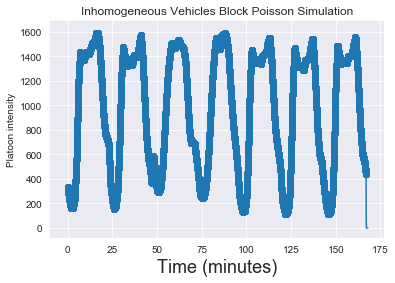

In [106]:
run_time = 168 #hours in a week

tf = TimeFunction((merged_grouped.index, merged_grouped.norm_count), dt=0.00028)

# We define a 1 dimensional inhomogeneous Poisson process with the
# intensity function seen above
in_poi = SimuInhomogeneousPoisson([tf], end_time=run_time, verbose=False)

# We activate intensity tracking and launch simulation
in_poi.track_intensity(0.1)
in_poi.simulate()

# We plot the resulting inhomogeneous Poisson process with its
# intensity and its ticks over time
fig, axes = plt.subplots()
plot_point_process(in_poi, ax=axes)
axes.set_title('Inhomogeneous Vehicles Block Poisson Simulation')

axes.yaxis.grid(True)
axes.set_xlabel('Time (hours)')
axes.set_ylabel('Platoon intensity')


In [110]:
df_poi = pd.DataFrame(data=in_poi.timestamps)

In [112]:
df_poi.T.head()

,0
0,0.000339
1,0.000354
2,0.000804
3,0.004222
4,0.004504


In [17]:
df = pd.read_pickle('{}Data/{}_{}_platoon_h2.pkl'.format(station, 2011, 2019))

In [18]:
df.head()

,Start,End,CLASS,GW_TOT,LENTH,Platoon,Length,Lane
0,2011-01-01 00:54:14,2011-01-01 00:54:14,[0],[3500],[674],False,1,4
1,2011-01-01 00:54:48,2011-01-01 00:54:48,[0],[5270],[839],False,1,4
2,2011-01-01 02:43:02,2011-01-01 02:43:02,[12],[19280],[1429],False,1,4
3,2011-01-01 02:54:33,2011-01-01 02:54:33,[0],[4400],[742],False,1,4
4,2011-01-01 03:12:30,2011-01-01 03:12:30,[0],[4090],[819],False,1,4


In [2]:
station = 'Ceneri'
start_year = 2011
end_year = 2019
headway = 2
seasonality = 'Daily'
minute = False
pickle = False

In [3]:

if seasonality == 'Daily':
    frequency = 24
    truck_count = 'Weekday'
    seasonal = 'Date_d'
    precision = 'Hour'

elif seasonality == 'Weekly':
    frequency = 7
    truck_count = 'Day of year'
    seasonal = 'Date_d'
    precision = 'Date_d'
    months = [3, 4, 5] #Taking months March, April, May

#Get the platoon data
df_platoon = pd.read_pickle('{}Data/{}_{}_platoon_h{}.pkl'.format(station, start_year, end_year, headway))
#df_platoon = df_platoon[df_platoon.Length > 1] #Only keep platoons that are at least of length 2
df_platoon['Weekday'] = df_platoon.Start.dt.weekday
df_platoon['Hour'] = df_platoon.Start.dt.hour
df_platoon['Date_d'] = df_platoon.Start.dt.date
df_platoon['Day of year'] = df_platoon.Start.dt.dayofyear
df_platoon['Year'] = df_platoon.Start.dt.year


KeyboardInterrupt: 

In [5]:
df_platoon['Year'] = df_platoon.Start.dt.year

In [36]:
df_platoon = df_platoon[df_platoon.Lane.isin([1, 4])] #Limit to the inner lanes

In [7]:
#Get the general truck data for normalization
df_truck = pd.read_pickle('{}Data/{}_{}_datetime.pkl'.format(station, start_year, end_year))
df_truck['Weekday'] = df_truck.Date.dt.weekday
df_truck['Hour'] = df_truck.Date.dt.hour
df_truck['Date_d'] = df_truck.Date.dt.date
df_truck['Day of year'] = df_truck.Date.dt.dayofyear
df_truck['Year'] = df_truck.Date.dt.year

In [37]:
if seasonality == 'Weekly':
    df_platoon_hour = df_platoon.groupby([truck_count]).Start.count().reset_index().rename(columns={'Start':'count'})

elif seasonality == 'Daily':
    if minute:
        df_platoon['Minute'] = df_platoon.Start.dt.minute
        df_platoon_hour = df_platoon.groupby([truck_count, precision, 'Minute']).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour
    else:
        df_platoon_hour = df_platoon.groupby([truck_count,precision, 'Length']).Start.count().reset_index().rename(columns={'Start':'count'}) #Total count by weekday/hour

In [38]:
df_platoon.Length = df_platoon.Length.apply(lambda x: str(x) if x <= 4 else '5 +')

TypeError: '<=' not supported between instances of 'str' and 'int'

In [20]:
df_platoon_hour.head()

,Weekday,Hour,Length,count
0,0,0,1,8110
1,0,0,2,128
2,0,0,3,3
3,0,1,1,7144
4,0,1,2,90


In [66]:

df_truck_date = df_truck.groupby([truck_count])[seasonal].nunique().reset_index().rename(columns={seasonal:'seasonal_count'}) #Total days by weekday represented
df_platoon_grouped = df_truck_date.merge(df_platoon_hour, on=truck_count)
df_platoon_grouped = df_platoon_grouped.set_index(truck_count)

#Normalizing
df_platoon_grouped['norm_count'] = df_platoon_grouped['count']/df_platoon_grouped['seasonal_count']


In [40]:
df_platoon_grouped.head()

,seasonal_count,Hour,Length,count,norm_count
Weekday,,,,,
0,443,0,1,6011,13.568849
0,443,0,2,92,0.207675
0,443,0,3,2,0.004515
0,443,1,1,5422,12.239278
0,443,1,2,68,0.153499


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose


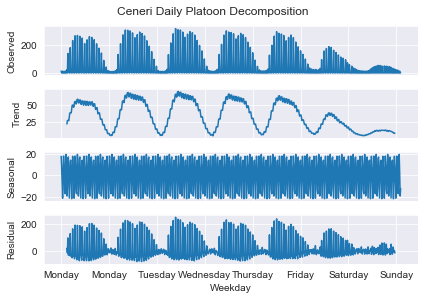

In [41]:

#Renaming days of the week
if seasonality == 'Daily':
    df_platoon_grouped = df_platoon_grouped.rename(index={0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: 'Thursday', 4: 'Friday',
                                                 5: 'Saturday', 6:'Sunday'})

if pickle:
    df_platoon_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}.pkl'.format(station, seasonality, start_year, end_year, headway))
else:
    #Plotting
    #df_platoon_grouped.norm_count.plot(title="{} Normalized Natural Truck Platoon with at least 2, count by hour".format(station))
    result = seasonal_decompose(df_platoon_grouped.norm_count, model='additive', freq=frequency)
    fig = result.plot()

    fig.suptitle('{} {} Platoon Decomposition'.format(station, seasonality), y=1.03)

    fig.savefig('Figures/{}/{}_platoon_season.png'.format(station, seasonality), bbox_inches='tight')

    plt.show()

In [42]:
df_platoon_grouped

,seasonal_count,Hour,Length,count,norm_count
Weekday,,,,,
Monday,443,0,1,6011,13.568849
Monday,443,0,2,92,0.207675
Monday,443,0,3,2,0.004515
Monday,443,1,1,5422,12.239278
Monday,443,1,2,68,0.153499
...,...,...,...,...,...
Sunday,443,22,3,5,0.011287
Sunday,443,22,4,1,0.002257
Sunday,443,23,1,5812,13.119639


In [43]:
    df_platoon_grouped.to_pickle('{}Data/platoon_{}_seasonality_{}_{}_h{}_length.pkl'.format(station, seasonality, start_year, end_year, headway))
